In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import shutil
import time

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [2]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    
    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    
    print("Uploaded to {}".format(destination_blob_name))
    
def insert_to_bq_gcs(bucket_name, source_directory_path, table_name):
    client = bigquery.Client()
    
    table_id = "gurihmas-corp-prd.ml.{}".format(table_name)
    
    job_config = bigquery.LoadJobConfig(schema = [bigquery.SchemaField("id", "INTEGER"),
                                                  bigquery.SchemaField("transaction_id", "STRING"),
                                                  bigquery.SchemaField("seller_id", "STRING"),
                                                  bigquery.SchemaField("image_filename_bucket", "STRING"),
                                                  bigquery.SchemaField("pred_label_f", "STRING"),
                                                  bigquery.SchemaField("conf_score_f", "FLOAT"),
                                                  bigquery.SchemaField("model_score_f", "FLOAT"),
                                                  bigquery.SchemaField("pred_label_s", "STRING"),
                                                  bigquery.SchemaField("conf_score_s", "FLOAT"),
                                                  bigquery.SchemaField("model_score_s", "FLOAT")],
                                        skip_leading_rows = 1,
                                        source_format = bigquery.SourceFormat.CSV)
    
    job_config.write_disposition = "WRITE_TRUNCATE"
    
    source_directory_path = "gs://{}/{}".format(bucket_name, 
                                                source_directory_path,
                                                table_name)
    
    load_job = client.load_table_from_uri(source_directory_path, 
                                          table_id,
                                          job_config = job_config)

    load_job.result()

    destination_table = client.get_table(table_id)
    print("Loaded {} rows".format(destination_table.num_rows))

## Data preprocessing

### Download Data

In [104]:
## copy existing/previous 1740 dataset
# source_dir = '/home/jupyter/data/development_3/images_dataset/asli'
# destination_dir = '/home/jupyter/data/development_4/images_dataset/asli'
# shutil.copytree(source_dir, destination_dir)

for image in tqdm((os.listdir('/home/jupyter/data/development_3/images_dataset/non-ktp'))):
    try:
        source_path = '/home/jupyter/data/development_3/images_dataset/non-ktp/{}'.format(image)
        dst_path = '/home/jupyter/data/development_4/images_dataset/non-ktp/{}'.format(image)
        shutil.copy(source_path, dst_path)
    except:
        pass

100%|██████████| 240/240 [00:00<00:00, 5793.30it/s]


In [130]:
# print(len(os.listdir('/home/jupyter/data/development_3/images_dataset/non-ktp')))
print('Asli: {}'.format(len(os.listdir('/home/jupyter/data/development_4/images_dataset/asli'))))
print('Fotocopy: {}'.format(len(os.listdir('/home/jupyter/data/development_4/images_dataset/fotocopy'))))
print('Non KTP: {}'.format(len(os.listdir('/home/jupyter/data/development_4/images_dataset/non-ktp'))))

Asli: 5731
Fotocopy: 5818
Non KTP: 5566


In [124]:
##check if new file dataset is already in the previous ones

string = '.jpg'
a = pd.DataFrame(additional_data['ktp_pict'].astype(str) + string)
a[a.ktp_pict.isin(os.listdir('/home/jupyter/data/development_3/images_dataset/non-ktp'))]

,ktp_pict
847,04620864-09fe-460e-bf14-029abc8351db.jpg


In [43]:
# shutil.rmtree('/home/jupyter/data/development_4/images_dataset/asli/.ipynb_checkpoints')

In [37]:
additional_data = pd.read_excel('/home/jupyter/data/development_4/Gurih Mas - Evaluate Data Sample.xlsx')
additional_data = additional_data[['ktp_pict','true_label']]
additional_data = additional_data[~additional_data.true_label.isnull()]
print(additional_data.shape)
additional_data.head()

(11000, 2)


,ktp_pict,true_label
0,10d0945d-5ec4-4ee9-bac5-55f8ab4cc701,KTP_Fotocopy
1,0000d496-0c45-41a6-8419-1b975f296075,KTP_Asli
2,d0779892-1295-4953-933b-702ce00fe6f0,KTP_Asli
3,20c6e6b2-d3d3-4871-9de3-573a95e8217b,KTP_Asli
4,0104f6b8-fd15-421f-be92-82f6fcfc924e,KTP_Asli


In [61]:
additional_data.true_label.value_counts()

KTP_Fotocopy    5318
KTP_Asli        4735
Non_KTP          947
Name: true_label, dtype: int64

In [38]:
url = 'gs://ldg_gurih_ktp/image/'
additional_data["url_path"]= url + additional_data["ktp_pict"].astype(str)
additional_data.head()

,ktp_pict,true_label,url_path
0,10d0945d-5ec4-4ee9-bac5-55f8ab4cc701,KTP_Fotocopy,gs://ldg_gurih_ktp/image/10d0945d-5ec4-4ee9-ba...
1,0000d496-0c45-41a6-8419-1b975f296075,KTP_Asli,gs://ldg_gurih_ktp/image/0000d496-0c45-41a6-84...
2,d0779892-1295-4953-933b-702ce00fe6f0,KTP_Asli,gs://ldg_gurih_ktp/image/d0779892-1295-4953-93...
3,20c6e6b2-d3d3-4871-9de3-573a95e8217b,KTP_Asli,gs://ldg_gurih_ktp/image/20c6e6b2-d3d3-4871-9d...
4,0104f6b8-fd15-421f-be92-82f6fcfc924e,KTP_Asli,gs://ldg_gurih_ktp/image/0104f6b8-fd15-421f-be...


In [39]:
image_asli = additional_data[additional_data.true_label=='KTP_Asli']['url_path'].tolist()
image_fotocopy = additional_data[additional_data.true_label=='KTP_Fotocopy']['url_path'].tolist()
image_non_ktp = additional_data[additional_data.true_label=='Non_KTP']['url_path'].tolist()

In [41]:
with open('/home/jupyter/data/development_4/data_asli.txt', 'w') as f:
    for line in image_asli:
        f.write(line)
        f.write('\n')
        
with open('/home/jupyter/data/development_4/data_fotocopy.txt', 'w') as f:
    for line in image_fotocopy:
        f.write(line)
        f.write('\n')
        
with open('/home/jupyter/data/development_4/data_non_ktp.txt', 'w') as f:
    for line in image_non_ktp:
        f.write(line)
        f.write('\n')

In [125]:
##add extension .jpg
final_image_sql_non_ktp = []

root = '/home/jupyter/data/development_4/images_dataset/non-ktp'

for file in os.listdir('/home/jupyter/data/development_4/images_dataset/non-ktp/'):
    head, tail = os.path.splitext(file)
    if not tail:
        src = os.path.join(root, file)
        dst = os.path.join(root, file + '.jpg')
        final_image_sql_non_ktp.append(file + '.jpg')
        print(dst)

        if not os.path.exists(dst): # check if the file doesn't exist
            os.rename(src, dst)

/home/jupyter/data/development_4/images_dataset/non-ktp/82fbd6b4-caa7-444a-a1fd-a487ad555901.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/cbe170aa-3359-419f-91ff-a1bb50cf801b.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/a6195f27-b432-449c-9f68-e5169d6bfb40.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/302851bc-b1f2-4635-b27a-b1bd9d16f9e3.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/86a50f8c-eb7c-4271-b554-f5da67911560.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/b0956547-780a-41ae-bcdb-e09b526ec291.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/4a051aea-ba22-4e87-9f8b-5fa53b5d85da.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/6e1677ff-1373-4e4d-9d3a-3b375daeeefd.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/b45c5a55-1862-4534-bdc9-6bfb557c1506.jpg
/home/jupyter/data/development_4/images_dataset/non-ktp/fba95b34-cfa8-432a-9eea-e557eed187f3.jpg
/home/jupyter/data/development

In [126]:
print('Avalaible Non KTP SQL image in bucket: {}'.format(len(final_image_sql_non_ktp)))

Avalaible Non KTP SQL image in bucket: 4380


In [127]:
final_image_sql_non_ktp_df = pd.DataFrame(final_image_sql_non_ktp,columns=['filename'])
final_image_sql_non_ktp_df['true_label'] = 'Non_KTP'

In [128]:
final_image_sql_non_ktp_df.head()

,filename,true_label
0,82fbd6b4-caa7-444a-a1fd-a487ad555901.jpg,Non_KTP
1,cbe170aa-3359-419f-91ff-a1bb50cf801b.jpg,Non_KTP
2,a6195f27-b432-449c-9f68-e5169d6bfb40.jpg,Non_KTP
3,302851bc-b1f2-4635-b27a-b1bd9d16f9e3.jpg,Non_KTP
4,86a50f8c-eb7c-4271-b554-f5da67911560.jpg,Non_KTP


In [129]:
final_image_sql_non_ktp_df.to_csv('/home/jupyter/data/development_4/list_image_sql_non_ktp.csv',index=False)

In [ ]:
# cat data_non_ktp_sql.txt | gsutil -m cp -I ./images_dataset/non-ktp

In [108]:
%%bigquery data_image_sql

select distinct a.ktp_pict, a.system_validated_info as true_label,
from (
select *,
from(
  select *,
        row_number() over (partition by transaction_id, ktp_pict order by load_datetime asc) rn
  from `gurihmas-corp-prd.ml.purchase_order_vw`
  )
where rn = 1
) a
left join ml.seller_vw b
on a.seller_id = b.id
where validated = 1 
and ((valid = 1 and system_validated_info in ('KTP_Asli', 'KTP_Fotocopy'))
or (valid = 0 and system_validated_info = 'Non_KTP'))

Downloading: 100%|██████████| 9127/9127 [00:02<00:00, 3603.96rows/s]


In [109]:
data_image_sql.head()

,ktp_pict,true_label
0,95f7e701-e8f0-4436-95e2-08343cbc28a9,Non_KTP
1,22f388dc-361e-436c-89f4-e6fbc3a902fb,Non_KTP
2,8e518b39-dde8-4e0e-b9c8-9337667896a6,Non_KTP
3,132ea24e-2550-4ec2-a970-b46adaa76ad9,Non_KTP
4,802d8cdc-ede2-473f-bc66-ef23eb81be0a,Non_KTP


In [114]:
data_image_sql_non_ktp = data_image_sql[data_image_sql['true_label']=='Non_KTP']
data_image_sql_non_ktp = data_image_sql_non_ktp[~data_image_sql_non_ktp.filename.isin(final_image_sql_non_ktp)]
print(data_image_sql_non_ktp.shape)

(9119, 2)


In [123]:
data_image_sql_non_ktp[data_image_sql_non_ktp['ktp_pict'].isin(os.listdir('/home/jupyter/data/development_4/images_dataset/non-ktp'))]


,ktp_pict,true_label
6,8d607a9e-6736-44c1-8619-49807219ebba,Non_KTP
31,bdfb50c3-de78-4575-b250-4ca6bf40b724,Non_KTP
74,f84f640e-c485-4706-ad74-9916550cccaa,Non_KTP
151,0251c380-a57d-480a-802b-163423f93f2c,Non_KTP
210,a2cb60e3-de9e-4c7e-849d-67435c6a0f2b,Non_KTP
...,...,...
8967,e9e3d4e3-19a3-4b9f-abf8-078f695e45ec,Non_KTP
9033,3ff276e5-657a-4de5-ba1d-b81516caad6c,Non_KTP
9051,cb623643-4044-4277-b790-067823cb8764,Non_KTP
9062,0ed9271d-c9e3-4db5-82b3-6b9ba8348519,Non_KTP


In [119]:
data_sample_image_sql_non_ktp = data_image_sql_non_ktp.sample(n=4500, random_state=123)

url = 'gs://ldg_gurih_ktp/image/'
data_sample_image_sql_non_ktp["url_path"]= url + data_sample_image_sql_non_ktp["ktp_pict"].astype(str)
print(data_sample_image_sql_non_ktp.shape)
data_sample_image_sql_non_ktp.head()

(4500, 3)


,ktp_pict,true_label,url_path
427,60bd34d6-df60-4343-bf5c-bc70555436ea,Non_KTP,gs://ldg_gurih_ktp/image/60bd34d6-df60-4343-bf...
8401,d5544e45-aa50-4573-9447-cada3f86311c,Non_KTP,gs://ldg_gurih_ktp/image/d5544e45-aa50-4573-94...
8105,c9c2a09b-fb47-43c8-9243-221ca38c279a,Non_KTP,gs://ldg_gurih_ktp/image/c9c2a09b-fb47-43c8-92...
6720,3043d03f-116d-4d42-bf2f-0178bdf38557,Non_KTP,gs://ldg_gurih_ktp/image/3043d03f-116d-4d42-bf...
6077,b0c35f94-7343-430d-ac26-881034564fe7,Non_KTP,gs://ldg_gurih_ktp/image/b0c35f94-7343-430d-ac...


In [120]:
image_sql_non_ktp = data_sample_image_sql_non_ktp['url_path'].tolist()

with open('/home/jupyter/data/development_4/data_non_ktp_sql.txt', 'w') as f:
    for line in image_sql_non_ktp:
        f.write(line)
        f.write('\n')

### Loading Dataset

In [132]:
# shutil.rmtree('/home/jupyter/data/development_4/images_dataset/.ipynb_checkpoints')

In [ ]:
PATH = '/home/jupyter/data/development_4/images_dataset'

train_dir = os.path.join(PATH, 'train')
# os.mkdir(train_dir)
validation_dir = os.path.join(PATH, 'validation')
# os.mkdir(validation_dir)

batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  # label_mode =  'int')

Found 17113 files belonging to 3 classes.
Using 13691 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  # label_mode =  'int')

Found 17113 files belonging to 3 classes.
Using 3422 files for validation.


In [135]:
##extract train file
file_train_paths = train_ds.file_paths
file_train = pd.DataFrame(file_train_paths)
file_train.columns = ['filename']
print(file_train.shape)
file_train.head()

(13691, 1)


,filename
0,/home/jupyter/data/development_4/images_datase...
1,/home/jupyter/data/development_4/images_datase...
2,/home/jupyter/data/development_4/images_datase...
3,/home/jupyter/data/development_4/images_datase...
4,/home/jupyter/data/development_4/images_datase...


In [136]:
filename_train = file_train.filename.str.rsplit("/", n=6, expand=True)
filename_train.columns = ['dir_1','dir_2','dir_3','dir_4','dir_5','dir_6','dir_7']

label_list = []
filename_train = filename_train[['dir_7','dir_6']]
for index,row in filename_train.iterrows():
    if row['dir_6'] == 'asli':
        label_list.append(0)
    elif row['dir_6'] == 'fotocopy':
        label_list.append(1)
    elif row['dir_6'] == 'non-ktp':
        label_list.append(2)
        
# filename_train = filename_train.dir_7.str.rsplit(".", n=1, expand=True)
# filename_train.columns = ['dir_1','dir_2']
# filename_train = filename_train[['dir_1']]

filename_train.columns=['filename','label']
filename_train['label'] = label_list
filename_train = filename_train.reset_index(drop=True)
print(filename_train.shape)
filename_train.head()

(13691, 2)


,filename,label
0,057bbd94-7b11-48dc-8565-585947153139.jpg,1
1,01b98492-227c-4398-8611-a868c5767dc7.jpg,1
2,00c99bc3-e596-4d34-bec4-dde957602fa2.jpg,0
3,3eba1860-5bc0-4c70-b3d2-118573bc2411.jpg,1
4,1258edfc-7727-4a8e-a28c-9bad529f2408.jpg,2


In [137]:
filename_train.to_csv('/home/jupyter/data/development_4/220707_filename_train.csv',index=False)

In [138]:
import os
 
all_filename = []
all_label = []

# Get the list of all files and directories
path_1 = "/home/jupyter/data/development_4/images_dataset/asli"
dir_list = os.listdir(path_1)
all_filename.extend(dir_list)
for i in range(0,len(dir_list)):
    all_label.append(0)

    
path_2 = "/home/jupyter/data/development_4/images_dataset/fotocopy"
dir_list = os.listdir(path_2)
all_filename.extend(dir_list)
for i in range(0,len(dir_list)):
    all_label.append(1)
    

path_3 = "/home/jupyter/data/development_4/images_dataset/non-ktp"
dir_list = os.listdir(path_3)
all_filename.extend(dir_list)
for i in range(0,len(dir_list)):
    all_label.append(2)
 
print(len(all_filename))
print(len(all_label))

17115
17115


In [139]:
###extract test file
file_all = pd.DataFrame()
file_all['filename'] = all_filename
file_all['label'] = all_label

# file_all = file_all.filename.str.rsplit(".", n=1, expand=True)
# file_all.columns = ['dir_1','dir_2']
# file_all = file_all[['dir_1']]
# file_all.columns=['filename']

filename_test = file_all[~file_all.filename.isin(filename_train.filename.tolist())]
print(filename_test.shape)

(3423, 2)


In [140]:
filename_test = filename_test.reset_index(drop=True)
filename_test.head()

,filename,label
0,960e1b2b-8ca3-47dd-953c-deb355840791.jpg,0
1,1451c0eb-2461-471e-81b5-eb7620c1955f.jpg,0
2,0e9317dc-ca80-4315-8d46-f9653cda877e.jpg,0
3,768afeb5-6092-4763-95f8-97612d0303d3.jpg,0
4,9201c59c-1fca-482b-8a1e-7b14362d174b.jpg,0


In [146]:
filename_test.to_csv('/home/jupyter/data/development_4/220707_filename_test.csv',index=False)

In [15]:
class_names = train_ds.class_names
print(class_names)

['asli', 'fotocopy', 'non-ktp']


Show the first nine images and labels from the training set:

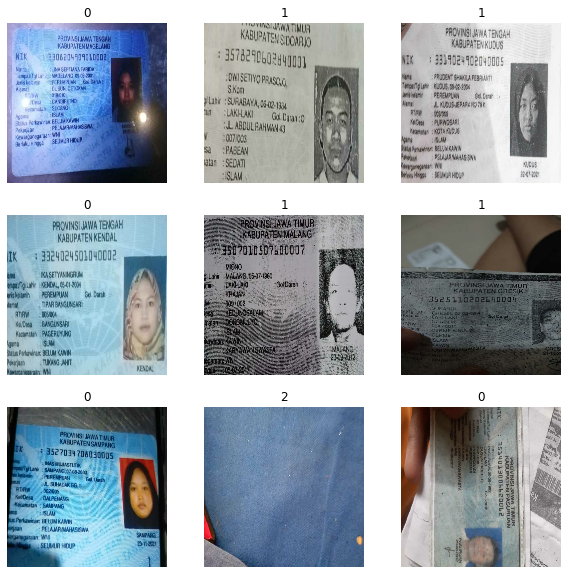

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.title(labels[i].numpy())
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [17]:
# val_batches = tf.data.experimental.cardinality(val_ds)
# test_dataset = val_ds.take(val_batches // 5)
# val_ds = val_ds.skip(val_batches // 5)

In [18]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 107


In [19]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))

Number of train batches: 428


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

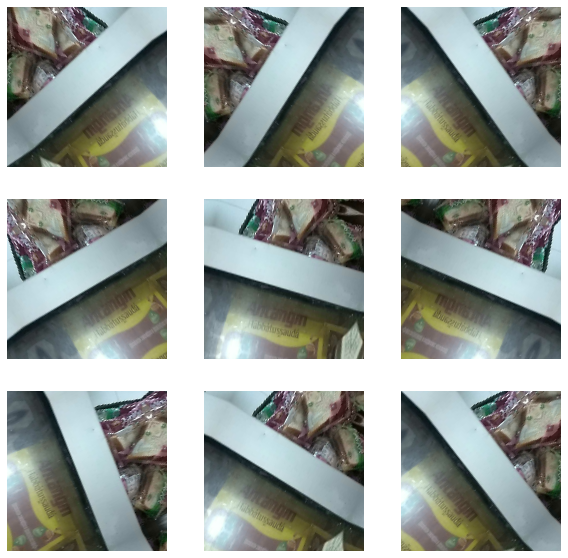

In [22]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [26]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [27]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [28]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [30]:
# prediction_layer = tf.keras.layers.Dense(1)
# prediction_layer = tf.keras.layers.Dense(len(class_names),activation='relu')
prediction_layer = tf.keras.layers.Dense(len(class_names),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [31]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.CategoricalCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [32]:
base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #from_logits=True
#               metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from_logits=True
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [166]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [33]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


107/107 [==============================] - 34s 306ms/step - loss: 1.5179 - accuracy: 0.2963


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.32
initial accuracy: 0.39


In [34]:
ts = time.time()
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 1/10
428/428 [==============================] - 178s 409ms/step - loss: 0.6011 - accuracy: 0.7509 - val_loss: 0.3432 - val_accuracy: 0.8805
Epoch 2/10
428/428 [==============================] - 178s 414ms/step - loss: 0.2869 - accuracy: 0.9007 - val_loss: 0.2289 - val_accuracy: 0.9319
Epoch 3/10
428/428 [==============================] - 178s 415ms/step - loss: 0.2189 - accuracy: 0.9294 - val_loss: 0.1786 - val_accuracy: 0.9468
Epoch 4/10
428/428 [==============================] - 177s 414ms/step - loss: 0.1894 - accuracy: 0.9394 - val_loss: 0.1519 - val_accuracy: 0.9556
Epoch 5/10
428/428 [==============================] - 177s 412ms/step - loss: 0.1620 - accuracy: 0.9488 - val_loss: 0.1364 - val_accuracy: 0.9608
Epoch 6/10
428/428 [==============================] - 173s 404ms/step - loss: 0.1498 - accuracy: 0.9541 - val_loss: 0.1255 - val_accuracy: 0.9652
Epoch 7/10
428/428 [==============================] - 174s 407ms/step - loss: 0.1455 - accuracy: 0.9534 - val_loss: 0.1168 -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

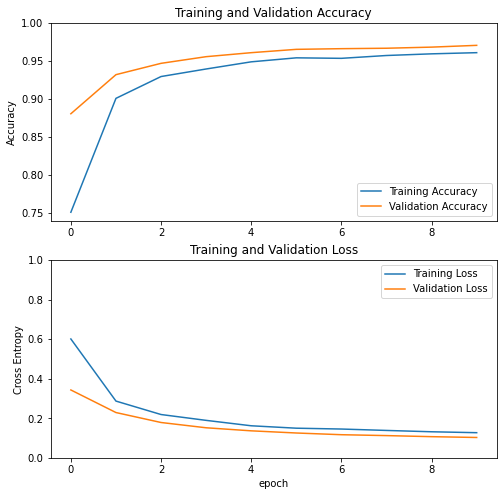

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [38]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #from_logits=True
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from_logits=True
#               metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#           optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#           metrics=['accuracy'])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
          metrics=['accuracy'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [40]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

ts = time.time()
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
print("Finished in {} s".format(time.time() - ts))

Epoch 10/20
428/428 [==============================] - 310s 718ms/step - loss: 0.1255 - accuracy: 0.9630 - val_loss: 0.0759 - val_accuracy: 0.9833
Epoch 11/20
428/428 [==============================] - 305s 713ms/step - loss: 0.0841 - accuracy: 0.9799 - val_loss: 0.0584 - val_accuracy: 0.9833
Epoch 12/20
428/428 [==============================] - 302s 704ms/step - loss: 0.0741 - accuracy: 0.9806 - val_loss: 0.0513 - val_accuracy: 0.9871
Epoch 13/20
428/428 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9852

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [45]:
len(acc)

10

In [177]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

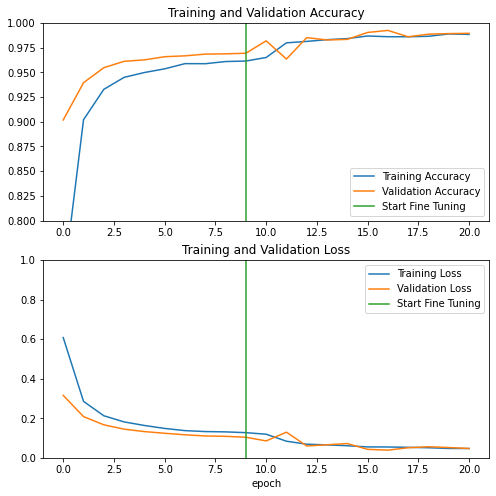

In [178]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Finaly you can verify the performance of the model on new data using test set.

In [179]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

107/107 [==============================] - 28s 261ms/step - loss: 0.0471 - accuracy: 0.9895
Test accuracy : 0.9894798398017883


In [180]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('/home/jupyter/model/upgraded_dataset/220707_mobilenet_dev_4.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


And now you are all set to use this model to predict if your pet is a cat or dog.

### Test to 1000 Evaluation Data

In [3]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('/home/jupyter/model/upgraded_dataset/220707_mobilenet_dev_4.h5')

# Show the model architecture
model.summary()

2022-07-08 10:13:07.097836: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [4]:
def convert_range(prediction_score, OldMin, OldMax):
    NewMax = 1
    NewMin = 0
    
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    NewValue = (((prediction_score - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue

def get_prediction_s(image_dir, model_name):
    test_img = tf.keras.utils.load_img(image_dir,
                                   grayscale = False,
                                   color_mode = 'rgb',
                                   target_size = (160,160,3),
                                   interpolation = 'nearest')
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model_name.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    class_names = ['KTP_Asli','KTP_Fotocopy','Non_KTP']
    pred_label = class_names[np.argmax(score)]
    
    conf_score = np.max(score)
    model_score = np.max(score)
    
    return pred_label, conf_score, model_score,score

In [5]:
from google.cloud import storage
from google.cloud import bigquery

%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [13]:
%%bigquery data_image_sql
select distinct image_filename_bucket, true_label
from(
select
  a.*,
  b.true_label
from
  ml.image_model_analysis a
  right outer join
    ml.far_sample_inspection b
    on a.image_filename_bucket = b.ktp_pict
where pred_label_f is not null
)
# select 
#   *
# from 
#     `gurihmas-corp-prd.ml.image_model_analysis`
# where
#     pred_label_f = 'Non_KTP'
#     and pred_label_s = 'KTP_Fotocopy'

Downloading: 100%|██████████| 971/971 [00:02<00:00, 434.25rows/s]


In [14]:
data_image_sql.head()

,image_filename_bucket,true_label
0,58c30d6d-d2bd-4eaf-97f6-1881a2f85e00,Non_KTP
1,d736917f-b653-479b-82fa-7b075d54f8fd,Non_KTP
2,a56d395e-5b50-4535-bd9a-c72ea8d525db,Non_KTP
3,d9bcbbb9-7ecf-4d63-b53a-47618c5b5718,Non_KTP
4,8eb38196-168c-43a8-94b3-635cd38bd411,Non_KTP


In [13]:
data_image = pd.read_excel('/home/jupyter/data/development_4/Gurih Mas - Evaluate Data Sample (Evaluation).xlsx')
# data_image = pd.read_csv('/home/jupyter/data/development_4/220708 Sample Evaluasi Prev Model Softmax 1000.csv',delimiter=";",index_col=False)
# data_image = data_image[['ktp_pict','true_label']]
# data_image = data_image[~data_image['true_label'].isnull()].reset_index(drop=True)
print(data_image.shape)
data_image.head()

(5000, 16)


,No,KTP Filename,Period,PIC,Previous In-House Model,In-House Production Model,Google Model,Development Model,True Label,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,00af93d3-38ab-4c08-99af-9d0d2a15f317,1-6 July,Mas Kemas,NaN,KTP_Asli,NaN,KTP_Asli,KTP_Asli,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,02f95c54-f5ac-45d2-a1fd-4ad153c15a76,1-6 July,Mas Kemas,NaN,KTP_Asli,NaN,KTP_Asli,KTP_Asli,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,00776d81-b559-4611-98b0-a05f2677b4e4,1-6 July,Mas Kemas,NaN,KTP_Asli,NaN,KTP_Asli,KTP_Asli,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,03a132b0-a0d7-4fa9-9572-497b1e80edda,1-6 July,Mas Kemas,NaN,KTP_Asli,NaN,KTP_Asli,KTP_Asli,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,00474209-783c-4ef0-a271-6b54631d9808,1-6 July,Mas Kemas,NaN,KTP_Asli,NaN,KTP_Asli,KTP_Asli,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data_image = data_image[data_image['Period']=='< 5 July'][['KTP Filename']].reset_index(drop=True)
data_image.columns=['filename']
data_image

,filename
0,01bc113b-6852-4843-a6e5-45b1869e6de4
1,009a5070-f4ee-40d4-864b-cf43059c621b
2,5e6e25e0-e32a-4ab9-8bae-ac9039642ce6
3,005bcc2d-37ac-4f2a-9b14-650a7879ab34
4,84864b67-496f-4b76-809d-18571cf9bcb0
...,...
3995,5d068d71-87b4-41c9-957e-cd88af5a8344
3996,585129da-ed73-4a92-b864-cc12b4ab268f
3997,6c0cf95a-d011-4692-ba88-f7deea41a0a1
3998,3cf393ef-b250-416f-9555-2b95689a74ac


In [1]:
# image_filename_bucket = '80a4be53-3ec4-4493-b32e-da9e538fd0a8'
# image_folder_bucket = 'image'
# image_full_path_bucket = '{}/{}'.format(image_folder_bucket, image_filename_bucket)

# image_download_directory = '/home/jupyter/data'
# image_full_path_dir = '{}/{}.jpg'.format(image_download_directory, image_filename_bucket)

# download_blob('ldg_gurih_ktp', image_full_path_bucket, image_full_path_dir)

# pred_label_s, conf_score_s, model_score_s,score = get_prediction_s(image_full_path_dir, model)
# print('File: {}'.format(image_filename_bucket))
# print(pred_label_s,conf_score_s,score)

In [15]:
pred_label = []
scoring = []

for i in tqdm(range(0, data_image.shape[0])):
# for i in range(0, 5):
    
    image_folder_bucket = 'image'
    image_download_directory = '/home/jupyter/data/development_4/image_test_model'
    image_filename_bucket = data_image.filename[i]
    image_full_path_bucket = '{}/{}'.format(image_folder_bucket, image_filename_bucket)
    image_full_path_dir = '{}/{}.jpg'.format(image_download_directory, image_filename_bucket)
    
    try:
        download_blob('ldg_gurih_ktp', image_full_path_bucket, image_full_path_dir)
        pred_label_s, conf_score_s, model_score_s,score = get_prediction_s(image_full_path_dir, model)
        # print(pred_label_s,conf_score_s,score)
        # print('')
        pred_label.append(pred_label_s)
        scoring.append(conf_score_s)
    
    except:
        pass
    
# img_array = plt.imread(image_dir)
# plt.imshow(img_array)
# print(score)

100%|██████████| 4000/4000 [1:23:20<00:00,  1.25s/it]


In [16]:
data_image['pred_label']=pred_label
data_image['score']=scoring

In [17]:
data_image.head()

,filename,pred_label,score
0,01bc113b-6852-4843-a6e5-45b1869e6de4,KTP_Fotocopy,0.573713
1,009a5070-f4ee-40d4-864b-cf43059c621b,KTP_Fotocopy,0.575866
2,5e6e25e0-e32a-4ab9-8bae-ac9039642ce6,KTP_Fotocopy,0.575924
3,005bcc2d-37ac-4f2a-9b14-650a7879ab34,KTP_Asli,0.572666
4,84864b67-496f-4b76-809d-18571cf9bcb0,KTP_Fotocopy,0.575052


In [18]:
data_image[['filename','pred_label']].to_csv('/home/jupyter/data/development_4/220708 Sample Evaluasi New Model Softmax 4000.csv',index=False)


In [ ]:
# join_eval = pd.merge(data_image,data_image_sql, how='left', left_on='ktp_pict', right_on='image_filename_bucket')
# join_eval.head()

In [ ]:
# join_eval[['ktp_pict','pred_label','pred_label_g']].groupby(['pred_label','pred_label_g']).ktp_pict.nunique()

## Upload to BQ and Storage

In [ ]:
from google.cloud import storage
from google.cloud import bigquery

In [ ]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    # bucket = storage_client.bucket(bucket_name)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

In [ ]:
def insert_to_bq_gcs(destination_uri):
    client = bigquery.Client()
    
    table_id = "gurihmas-corp-prd.ml.220519_result_all_test_data"
    
    job_config = bigquery.LoadJobConfig(schema=[
        bigquery.SchemaField("filename", "STRING"),
        bigquery.SchemaField("predict", "INT64"),
        bigquery.SchemaField("predict_class", "STRING"),
        bigquery.SchemaField("score", "FLOAT"),],skip_leading_rows=1,field_delimiter=",",source_format=bigquery.SourceFormat.CSV)
    job_config.write_disposition = "WRITE_TRUNCATE"
    
    load_job = client.load_table_from_uri(
        destination_uri, table_id, job_config=job_config
    )

    load_job.result()

    destination_table = client.get_table(table_id)
    print("Loaded {} rows.".format(destination_table.num_rows))

In [ ]:
##upload model to cloud storage
# upload_blob('ml_nitro','/home/jupyter/data/220519_sample_data_all_result.csv','ops/data/220519_sample_data_all_result.csv')

##upload table summary to bq
# insert_to_bq_gcs("gs://ml_nitro/ops/data/220519_sample_data_all_result.csv")
